In [10]:
import keras
from keras.models import Sequential
from keras.layers import Input,Dense,Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D,MaxPooling2D
from keras.optimizers import SGD
from keras.models import Model
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd
import numpy as np
import matplotlib.pyplot as mp
import cv2
import os
import gc
import sys
import h5py, time,random

In [4]:
BASE = './Furniture'

In [5]:
classes = os.listdir(BASE)
classes = [i for i in classes if i[0] is not '.']
classes

['shelf_jpg',
 'chair_jpg',
 'lamp_jpg',
 'stool_jpg',
 'sofa_jpg',
 'wardrobe_jpg',
 'bed_jpg',
 'table_jpg']

In [6]:
class_sizes = [0]*len(classes)
for i in range(len(classes)):
    for k in os.listdir(BASE + "/" + classes[i]):
        if k[0] != '.':
            class_sizes[i]+=1
print(class_sizes)
print("No of examples: " + str(sum(class_sizes)))

[202, 671, 412, 363, 675, 304, 592, 613]
No of examples: 3832


In [7]:
def augment(image):
    resized = cv2.resize(image, (128,128), interpolation=cv2.INTER_AREA)
    lower_white = np.array([220, 220, 220], dtype=np.uint8)
    upper_white = np.array([255, 255, 255], dtype=np.uint8)
    mask = cv2.inRange(resized, lower_white, upper_white) # could also use threshold
    res = cv2.bitwise_not(resized, resized, mask)
    colored_red = resized.copy()
    colored_blue = resized.copy()
    colored_green = resized.copy()
    colored_red[mask == 255] = (255, random.randint(0,50), random.randint(0,50))
    colored_blue[mask == 255] = (random.randint(0,50), random.randint(0,50),255)
    colored_green[mask == 255] = (random.randint(0,50), 255,random.randint(0,50))
    return colored_red,colored_blue,colored_green

In [8]:
def generate_split(file_list,classname,split):
    
    X = []
    Y = []
    # Retreive image data first
    for i in file_list:
        im = cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB)
        res = cv2.resize(im, (128,128)) 
        X.append(res)
        Y.append(classname)
    
    size = len(file_list) 
    # Split according to split
    split_point = int(split * size)
    return X[:split_point],X[split_point:],Y[:split_point],Y[split_point:]

In [9]:
X_train = []
X_test = []
Y_train = []
Y_test = []
split = 0.9
print("Split would be " + str(split*100) + " and " + str(100*(1-split)))

for i in range(len(classes)):
    class_file_list = []
    print("Class: " + classes[i] + " has " + str(class_sizes[i]) + " examples")
    for k in os.listdir(BASE + "/" + classes[i]):
        if k[0] != '.':
            path = BASE + "/" + classes[i] + "/" + k
            class_file_list.append(path)

    X_train_class,X_test_class,Y_train_class,Y_test_class = generate_split(class_file_list,i,split)
    X_train = X_train + X_train_class
    Y_train = Y_train + Y_train_class
    X_test = X_test + X_test_class
    Y_test = Y_test + Y_test_class

X_train = np.array(X_train)/255
X_test = np.array(X_test)/255
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

print("Train set size is: " + str(sys.getsizeof(X_train)/pow(1024,3)) + " GBs")

Split would be 90.0 and 9.999999999999998
Class: shelf_jpg has 202 examples
Class: chair_jpg has 671 examples
Class: lamp_jpg has 412 examples
Class: stool_jpg has 363 examples
Class: sofa_jpg has 675 examples
Class: wardrobe_jpg has 304 examples
Class: bed_jpg has 592 examples
Class: table_jpg has 613 examples
Train set size is: 1.2608643919229507 GBs


In [10]:
print("Training Size:" , X_train.shape)
print("Test Size:", X_test.shape)

Training Size: (3443, 128, 128, 3)
Test Size: (389, 128, 128, 3)


In [11]:
gc.collect()
train_size = X_train.shape[0]
permutation_train = np.random.permutation(train_size)
X_train = X_train[permutation_train]
Y_train = Y_train[permutation_train]

test_size = X_test.shape[0]
permutation_test = np.random.permutation(test_size)
X_test = X_train[permutation_test]
Y_test = Y_train[permutation_test]

['shelf_jpg', 'chair_jpg', 'lamp_jpg', 'stool_jpg', 'sofa_jpg', 'wardrobe_jpg', 'bed_jpg', 'table_jpg']


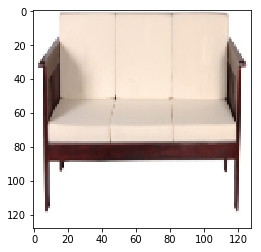

4


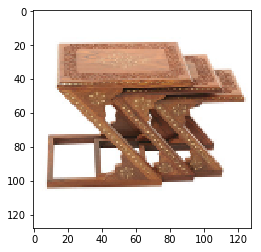

1


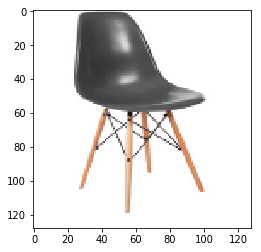

1


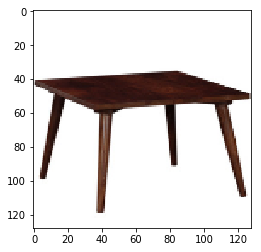

7


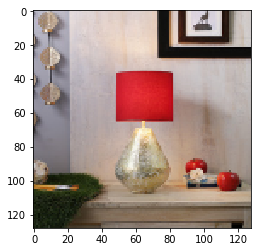

2


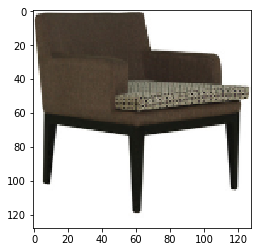

1


In [12]:
print(classes)
count = 0
for i,j in zip(X_train[1200:-1],Y_train[1200:-1]):
    mp.imshow(i)
    mp.show()
    print(j)
    count+=1
    if count > 5 :
        break

In [8]:
# One Hot Encoding
def one_hot(X,Y):
    size = X.shape[0]
    b = np.zeros((size,8))
    b[np.arange(size),Y] = 1
    Y_enc = b

    return Y_enc

In [14]:
Y_train_enc = one_hot(X_train,Y_train)
Y_test_enc = one_hot(X_test,Y_test)

In [32]:
def ConvModel(input_shape):
    
    #Define the Input Shape
    X_input = Input(input_shape)
    X = X_input
    # CONV -> MAXPOOL *3
    X = ZeroPadding2D(padding=(2,2),data_format='channels_last')(X)
    X = Conv2D(40,(7,7), strides = (2,2), name = 'conv0', data_format = 'channels_last')(X)
    X = BatchNormalization(axis = 3,name = 'bn0')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2), name='max_pool0', data_format = 'channels_last')(X)
    X = Dropout(0.35)(X)

    # Layer 2
    X = Conv2D(30,(3,3), strides = (1,1), name = 'conv1', data_format = 'channels_last')(X)
    X = BatchNormalization(axis = 3,name = 'bn1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2), name='max_pool1', data_format = 'channels_last')(X)
    X = Dropout(0.25)(X)
    
    # Layer 3
    X = Conv2D(30,(3,3), strides = (1,1), name = 'conv2', data_format = 'channels_last')(X)
    X = BatchNormalization(axis = 3,name = 'bn2')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2), name='max_pool2', data_format = 'channels_last')(X)
    X = Dropout(0.25)(X)

    X = Flatten()(X)
    X = Dense(128,activation='relu',name='fc0')(X)
    X = Dense(128,activation='relu',name='fc1')(X)
    X = Dense(8,activation='softmax',name='final')(X)
    
    model = Model(inputs = X_input , outputs = X , name = 'ConvModel')
    return model

In [33]:
model = ConvModel(X_train.shape[1:])
mnist_model = model.compile(optimizer='adam',loss='categorical_crossentropy',metrics = ['accuracy'])
model.load_weights('pepperfry_weights_augmented.h5')
model.save('pepperfry_model.h5')

In [17]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 132, 132, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 63, 63, 40)        5920      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 63, 63, 40)        160       
_________________________________________________________________
activation_1 (Activation)    (None, 63, 63, 40)        0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 31, 31, 40)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 40)        0         
__________

In [24]:
init = time.time()
print(X_train.shape , Y_train.shape)
history = model.fit(x=X_train, 
                    y=Y_train_enc, 
                    batch_size=512, 
                    epochs=5,
                    validation_split=0.1,
                   )
fin = time.time()
print("Time for train:",fin-init)

(3443, 128, 128, 3) (3443,)
Train on 3098 samples, validate on 345 samples
Epoch 1/5
3098/3098 [==============================] - 49s 16ms/step - loss: 0.0568 - acc: 0.9806 - val_loss: 0.1519 - val_acc: 0.9478
Epoch 2/5
3098/3098 [==============================] - 53s 17ms/step - loss: 0.0512 - acc: 0.9829 - val_loss: 0.0323 - val_acc: 0.9884
Epoch 3/5
3098/3098 [==============================] - 56s 18ms/step - loss: 0.0399 - acc: 0.9858 - val_loss: 0.1413 - val_acc: 0.9420
Epoch 4/5
3098/3098 [==============================] - 57s 18ms/step - loss: 0.0495 - acc: 0.9835 - val_loss: 0.3593 - val_acc: 0.8928
Epoch 5/5
3098/3098 [==============================] - 60s 19ms/step - loss: 0.0496 - acc: 0.9842 - val_loss: 0.0453 - val_acc: 0.9884
Time for train: 275.59057998657227


In [18]:
preds = model.evaluate(x=X_test,y=Y_test_enc)

print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

mp.plot(history.history['loss'])
mp.xlabel('Epochs')
mp.ylabel("Loss")
mp.show()

389/389 [==============================] - 2s 5ms/step

Loss = 0.05373535330012961
Test Accuracy = 0.9820051413881749


NameError: name 'history' is not defined

In [26]:
model.save_weights('pepperfry_weights.h5')

#### Tester
##### Input
A base directory that contains files with the same hierarchy as the Furniture Dataset.
Example: Test_Directory / 
            - bed_jpg
            - chair_jpg
            - lamp_jpg
            - shelf_jpg
            - sofa_jpg
            - stool_jpg
            - table_jpg
            - wardrobe_jpg
Class labels are from 0-7 in the defined as 
- shelf_jpg -> 0
- chair_jpg -> 1
- lamp_jpg -> 2
- stool_jpg -> 3
- sofa_jpg -> 4
- wardrobe_jpg -> 5
- bed_jpg -> 6
- table_jpg -> 7

The tester will convert the images into X_test and Y_test(one_hot).

##### Output
Y_pred and Accuracy

In [25]:
def tester(base_directory):
    
    classes = os.listdir(base_directory)
    classes = [i for i in classes if i[0] is not '.']
    
    model = load_model('pepperfry_model.h5')
    
    X_test_input = []
    Y_test_input = []
    
    for c in range(len(classes)):
        class_files = []
        for i in os.listdir(base_directory + '/' + classes[c]):
            if i[0] != '.':
                path = base_directory + '/' + classes[c] + '/' + i
                image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
                res = cv2.resize(image, (128,128))
                X_test_input.append(res)
                Y_test_input.append(c)
    
    X_test_input = np.array(X_test_input)/255.
    Y_test_input = np.array(Y_test_input)
    
    print("X_test shape:",X_test_input.shape)
    print("Y_test_shape:",Y_test_input.shape)
    
    Y_test_input_enc = np.array(one_hot(X_test_input,Y_test_input))
    
    preds = model.evaluate(x=X_test_input,y=Y_test_input_enc)
    Y_test_pred_enc = model.predict(X_test_input)
    Y_test_pred = np.argmax(Y_test_pred_enc,axis = 1)
    confusion_mat = confusion_matrix(Y_test_input, Y_test_pred, labels=[i for i in range(len(classes))])
    precision,recall,fscore,_ = precision_recall_fscore_support(Y_test_input, Y_test_pred, average='macro')
    
    print("Accuracy:",str(preds[1]))
    print("Precision:",precision)
    print("Recall",recall)
    print("F-Score",fscore)
    print("Confusion Matrix")
    print(conf_matrix)
    
    return str(preds[1]),confusion_mat,precision,recall,fscore       
    

In [26]:
accuracy , conf_matrix , precision, recall, fscore  = tester('Furniture')

X_test shape: (3832, 128, 128, 3)
Y_test_shape: (3832,)
3832/3832 [==============================] - 25s 6ms/step
Accuracy: 0.9775574111490508
Precision: 0.9755440704695529
Recall 0.9761328876741335
F-Score 0.9755477396340364
Confusion Matrix
[[197   0   0   1   3   1   0   0]
 [  1 658   0   4   6   0   2   0]
 [  0   0 410   1   0   0   1   0]
 [  3   0   0 351   2   0   4   3]
 [  2   0   0   1 670   0   2   0]
 [  7   1   1   2   1 291   1   0]
 [  0   0   0   0   0   0 592   0]
 [  0   2   0   4   5   1  24 577]]


In [27]:
accuracy , conf_matrix , precision, recall, fscore  = tester('Test')

X_test shape: (159, 128, 128, 3)
Y_test_shape: (159,)
159/159 [==============================] - 2s 14ms/step
Accuracy: 0.8427672903492766
Precision: 0.8482865818392133
Recall 0.8434210526315788
F-Score 0.8393483328265938
Confusion Matrix
[[197   0   0   1   3   1   0   0]
 [  1 658   0   4   6   0   2   0]
 [  0   0 410   1   0   0   1   0]
 [  3   0   0 351   2   0   4   3]
 [  2   0   0   1 670   0   2   0]
 [  7   1   1   2   1 291   1   0]
 [  0   0   0   0   0   0 592   0]
 [  0   2   0   4   5   1  24 577]]


In [28]:
accuracy , conf_matrix , precision, recall, fscore  = tester('Test2')

X_test shape: (236, 128, 128, 3)
Y_test_shape: (236,)
236/236 [==============================] - 2s 10ms/step
Accuracy: 0.9830508474576272
Precision: 0.9848003629764065
Recall 0.9821428571428572
F-Score 0.9831403173508437
Confusion Matrix
[[12  1  0  0  5  2  0  0]
 [ 1 14  3  0  1  0  0  1]
 [ 0  3 16  1  0  0  0  0]
 [ 0  1  0 17  0  0  0  2]
 [ 0  0  0  0 20  0  0  0]
 [ 0  0  1  0  0 18  0  0]
 [ 0  0  0  0  0  0 20  0]
 [ 0  0  0  2  0  1  0 17]]


#### Google Scraped Images

In [29]:
accuracy , conf_matrix , precision, recall, fscore  = tester('Test3')

X_test shape: (1154, 128, 128, 3)
Y_test_shape: (1154,)
1154/1154 [==============================] - 7s 6ms/step
Accuracy: 0.951473136915078
Precision: 0.9405384601656344
Recall 0.9471548326635459
F-Score 0.9431001017141873
Confusion Matrix
[[27  0  0  0  1  0  0  0]
 [ 0 27  0  0  1  0  0  0]
 [ 0  0 32  0  0  0  0  0]
 [ 0  0  0 28  0  0  0  0]
 [ 0  0  0  0 36  0  0  0]
 [ 2  0  0  0  0 26  0  0]
 [ 0  0  0  0  0  0 28  0]
 [ 0  0  0  0  0  0  0 28]]
